## Benchmarks Tutorial

In this tutorial, we demonstrate how summit can be used to optimize reactions automatically. We are going to optimize a nucleophilic aromatic substitution (SnAr) reaction through virtual experiments.

![](assets/hone_2016_snar_chemistry.png)

2,4 dinitrofluorobenzene (**1**) undergoes nucleophilic attack by pyrrolidine (**2**) to form the desired product **3**. Two side products **4** and **5** can also be formed. Overall, we want to maximize the amount of product formed and minimze side product formation and waste.

The kinetics of this reaction were published by [Hone et al.](http://xlink.rsc.org/?DOI=C6RE00109B) We imagine a scenario where this reaction is to be optimized in a flow reactor. We have set up a "virtual" flow chemistry reactor in the `SnarBenchmark` using the published kinetics and standard chemical engineering equations. You simply supply the reaction conditions to `SnarBenchmark` and it will give back the results of a virtual experiment with those conditions. Think of it as your virtual laboratory.

Below, we start importing the needed packages and setting up the virtual lab.

In [229]:
from summit.benchmarks import SnarBenchmark
from summit.utils.dataset import DataSet

In [226]:
# Instantiate the lab
lab = SnarBenchmark()
lab.domain

Name,Type,Description,Values
tau,"continuous, input",residence time in minutes,"[0.5,2]"
equiv_pldn,"continuous, input",equivalents of pyrrolidine,"[1.5,3.5]"
conc_dfnb,"continuous, input","concentration of 2,4 dinitrofluorobenenze at reactor inlet (after mixing) in M","[0.1,0.2]"
temperature,"continuous, input",Reactor temperature in degress celsius,"[30,120]"
sty,"continuous, maximize objective",space time yield (kg/m^3/h),"[0,100]"
e_factor,"continuous, minimize objective",E-factor,"[0,10]"


We print out the `domain` which describes the optimization problem associated with `SnarBenchmark`.  The objectives are to maximize space-time yield (STY) and minimize E-factor. STY is the mass of product produced per reactor volume per time, and E-factor is the ratio of the mass of waste to mass of product. Waste is the amount of side product produced (**4** and **5**), unreacted starting material and solvent in the reactor outlet stream. By minimizing E-factor, we are effectively maximizing selectivity and reaction "greeness" at the same time.  

We optimize the reactions by changing the residence time, inlet concentration of 2,4-dinitrofluorobenzene (**1**), equivalences of of pyrrolidine (**2**), and temperature. 

## Running a single experiment

Before we do any optimization, let's get a sense of how our virtual laboratory works. Below, we run one virtual experiment with relatively mild conditions (residence time = 0.5 minutes, equiv of **2** = 1.5, concentration of **1** = 0.1 M and T = 30.0°C).

In [228]:
# Create some test conditions
columns = [v.name for v in lab.domain.variables]
values  =   {('tau', 'DATA'): 1.5,  # minutes
             ('equiv_pldn', 'DATA'): 0.5,  
             ('conc_dfnb', 'DATA'): 0.1, #molar
             ('temperature', 'DATA'): 30.0, # degrees celsius
              }
conditions = DataSet([values], columns=columns)

# Run the conditions
lab.reset()
results = lab.run_experiments(conditions)
results

,tau,equiv_pldn,conc_dfnb,temperature,sty,e_factor,computation_time,experiment_time,strategy
0,1.5,0.5,0.1,30.0,168.958672,191.260294,0.0,0.004953,NaN


In the above code, we put our reaction conditions in a summit DataSet, which is a Pandas dataframe that allows us to specify certain columns as metadata. For example, the experiment time column is a metadata column. That's why the values dictionary has tuples that specify the type of columns (DATA vs. METADATA).  

We run the virtual experiment using `lab.run_experiments`, which integrates the kinetic equations at the conditions given. The results are printed out.

We can see that these conditions give a relatively low space-time yield (a good value would be around 3,000 kg/m^3/h) and high E-factor (a good value would be <30).  So, let's try to optimze the conditions. 

## Optimization using TSEMO

In summit, methods for optimizing reactions are called strategies. There are X strategies available, each with different capabilities. The advantage of using summit is that we can quickly and easily test out different strategies on a problem to see which one performs best. 

We are going to first use a random strategy as a baseline, where each experiment is selected at random. Any advanced strategies should at least perform better than this.

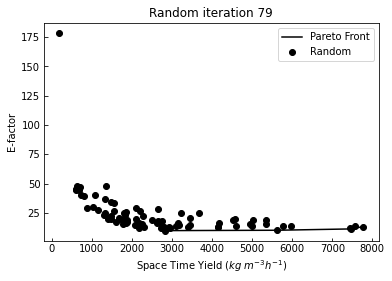

In [241]:
from summit.benchmarks import SnarBenchmark
from summit.strategies import Random
import matplotlib.pyplot as plt
from IPython.display import clear_output

#Set up the laboratory
lab = SnarBenchmark()
lab.reset()

# Instantiate random sampling strategy
random = Random(lab.domain)
names = [r'Space Time Yield ($kg \; m^{-3} h^{-1}$)', 'E-factor']

# Run random sampling
print("Running TSEMO")
for i in range(80):
    
    # Get TSEMO suggestions
    experiments = random.suggest_experiments(1)
    
    # Run experiments
    results = lab.run_experiments(experiments)

    # Update plot every 5 iterations
    if i % 5 == 0:
        clear_output(wait=True)
        fig, ax = lab.pareto_plot()
        ax.set_xlabel(names[0])
        ax.set_ylabel(names[1])
 
        ax.tick_params(direction='in')
        plt.show(fig)
        print(f"Running random iterations {i+1} to {i+5}")

clear_output(wait=True)
fig, ax = lab.pareto_plot()
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_title(f"Random iteration {i}")
ax.tick_params(direction='in')
plt.show(fig)

In the above code, we start by creating the laboratory as we did before. We then setup the random strategy using `Random`and ask it for experiments using `suggest_experiments`. We run those experiments and plot the results. 

The above plot is a pareto plot. Each point in the above plot represents a different set of reaction conditons. The pareto front shows the conditions that optimize space-time yield at the cost of E-factor and vice versa. 

Let's now try something more advances. TSEMO is a multiobjective optimization strategy, meaning that it can find the tradeoffs between two competing objectives. Below, is all the code needed to run TSEMO. Note that running this code will take a few minutes.

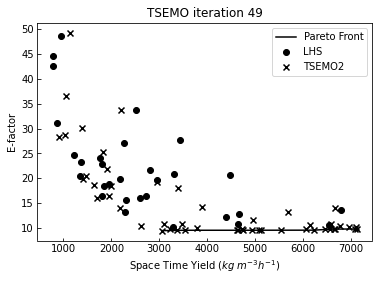

In [242]:
from summit.benchmarks import SnarBenchmark
from summit.strategies import TSEMO2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

#Set up the laboratory
lab = SnarBenchmark()
lab.reset()

# Set up the TSEMO strategy
tsemo = TSEMO2(lab.domain, random_rate=0.25)
names = [r'Space Time Yield ($kg \; m^{-3} h^{-1}$)', 'E-factor']

# Get and run initial experiments. TSEMO uses latin hypercube for initial designs
print("Starting initial design")
experiments = tsemo.suggest_experiments(30)
lab.run_experiments(experiments)

# Plot initial experiments
fig, ax = lab.pareto_plot()
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
plt.show(fig)

# Run TSEMO
print("Running TSEMO")
for i in range(50):
    # Transform objective data to log
    previous_results = lab.data.copy()
    previous_results[('sty', 'DATA')] = np.log(previous_results['sty'])
    previous_results[('e_factor', 'DATA')] = np.log(previous_results['e_factor'])
    
    # Get TSEMO suggestions
    experiments = tsemo.suggest_experiments(1, previous_results=previous_results)
    
    # Run experiments
    results = lab.run_experiments(experiments)

    # Update plot every 5 iterations
    if i % 5 == 0:
        clear_output(wait=True) # Clear the previous plot
        fig, ax = lab.pareto_plot()
        ax.set_xlabel(names[0])
        ax.set_ylabel(names[1])
        ax.set_title(f"TSEMO iteration {i}")
        ax.set_yscale('log')
        ax.tick_params(direction='in')
        plt.show(fig)
        print(f"Running TSEMO iterations {i+1} to {i+5}")

# Make final plot
clear_output(wait=True)
fig, ax = lab.pareto_plot()
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_title(f"TSEMO iteration {i}")
ax.tick_params(direction='in')
plt.show(fig)

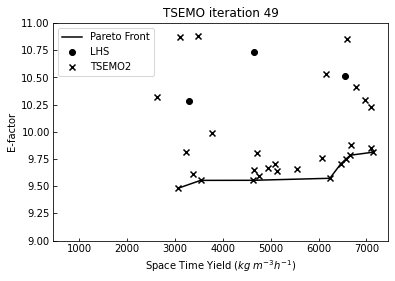

In [249]:
# Just showing the pareto front
clear_output(wait=True)
fig, ax = lab.pareto_plot()
ax.set_xlabel(names[0])
ax.set_ylabel(names[1])
ax.set_title(f"TSEMO iteration {i}")
ax.set_ylim(9, 11)
ax.tick_params(direction='in')
plt.show(fig)

The code above is very similar to the random sampling code with some minor changes. We start by asking TSEMO for 30 experiments. Since we don't pass any previous results, it will use latin hypercube sampling, which is a space-filling random sampling technique, to get initial experiments. As shown in the above plot, the points choosen are quite random and give a good sampling of the space.

Then, we run TSEMO in earnest for 50 more iterations, asking for one experiment each time. Note that we transform the objectives into log space, since this has been shown to improve the performance of optimization algorithms. 

As we ask for more experiments, we better see the pareto front, which represents the trade off between space-time yield and E-factor. We show the pareto front more clearly below. In the second plot, its clear how TSEMO chooses many more optimal or near optimal points than random sampling.

Below we print out the pareto front conditions for the SnAr reaction.

In [250]:
from summit.utils.multiobjective import pareto_efficient

objectives = [v.name for v in lab.domain.variables
              if v.is_objective]
data = lab.data[objectives].copy()

#Handle minimize objectives
for objective in objectives:
    if not lab.domain[objective].maximize:
        data[objective] = -1.0*data[objective]

values, indices = pareto_efficient(data.to_numpy(),
                                   maximize=True)

pareto_data = lab.data.iloc[indices]
pareto_data

,tau,equiv_pldn,conc_dfnb,temperature,sty,e_factor,computation_time,experiment_time,strategy
388,0.846752,1.817991,0.494767,47.544955,6663.547974,9.784374,4.712905,0.004277,TSEMO2
713,1.605081,1.293420,0.498311,69.999020,3535.282155,9.553033,3.900388,0.004382,TSEMO2
867,0.845041,1.296763,0.488834,84.814663,6564.653961,9.745980,4.398601,0.003978,TSEMO2
274,0.864869,1.324289,0.496886,92.616767,6466.718639,9.705964,4.014828,0.004296,TSEMO2
749,0.774055,1.353482,0.488045,87.629348,7135.611494,9.812046,4.073402,0.004100,TSEMO2
876,0.901703,1.131961,0.499655,93.398575,6236.145167,9.572239,6.082278,0.007380,TSEMO2
112,1.854376,1.141609,0.499815,74.038180,3063.583040,9.480495,6.756613,0.004294,TSEMO2
862,1.223413,1.281558,0.499545,79.013165,4636.978563,9.553696,6.201299,0.006104,TSEMO2
